# Plotting functions for macrophysical delays

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.stats import gaussian_kde
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const
import seaborn as sns
import matplotlib.lines as mlines
from matplotlib.ticker import FixedLocator, FuncFormatter
import utils as util

In [2]:
fpaths = matplotlib.font_manager.findSystemFonts()
plt.rc('font', family='Nimbus Roman', size = 9)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' #for \text command
colour_map = sns.color_palette("husl", 8)

In [3]:
LITTLE_H = 0.679
VOLUME = (100/LITTLE_H)**3  # cMpc^3

## Delays only (no accretion)

In [4]:
indices = []
primary_mass = []
secondary_mass = []
time_delays = []
galaxies_merged = []
galaxy_separation = []
redshifts_galaxies = []
simulation_redshifts = []
halo_mass_at_numerical_merger = []
path = '../data/generated_data/delay_data/'
# path = '/cosma/home/dp012/dc-butt3/BHs_FABLE/BH_mergers/data/final_delays_fixed_distance/'
files = os.listdir(path)
H0 = LITTLE_H * 100
Om0 = 0.3065
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
for file in files:
    with open(path + file, 'r') as f:
        for line in f:
            entries = line.strip().split()
            index_1 = int(entries[0])
            index_2 = int(entries[1])
            index = f'{index_1}_{index_2}'
            if index not in indices:
                indices.append(index)
                m1 = float(entries[2])
                m2 = float(entries[3])
                if m1 < m2:
                    primary_mass.append(m2)
                    secondary_mass.append(m1)
                else:
                    primary_mass.append(m1)
                    secondary_mass.append(m2)
                redshift_merger = float(entries[4])
                simulation_redshifts.append(redshift_merger)
                redshift_galaxies = float(entries[5])
                redshifts_galaxies.append(redshift_galaxies)
                galaxies_merged.append(entries[6] == 'True')
                galaxy_separation.append(float(entries[7])) # this is in kpc

                # calculate the time delay from the redshifts
                age_bh = cosmo.age(redshift_merger)
                age_galaxy = cosmo.age(redshift_galaxies)
                time_delay = (age_galaxy - age_bh).to(u.Gyr).value
                time_delays.append(time_delay)

print('The total number of major merger events is: ', len(indices))
zero_indices = [i for i, delay in enumerate(time_delays) if delay == 0]
print('Number of major mergers with no delay: ', len(zero_indices))
not_merged_indices = [i for i, merged in enumerate(galaxies_merged) if not merged]    
print('Number of mergers that do not merge by redshift 0: ', len(not_merged_indices))
time_delays_without_non_mergers = np.delete(time_delays, not_merged_indices)

The total number of major merger events is:  10709
Number of major mergers with no delay:  499
Number of mergers that do not merge by redshift 0:  3176


### Distribution of time delays

In [6]:
def generate_time_delay(delay_until_0, delay_distribution):
    """
    Generate a time delay from the distribution of time delays, given a minimum time delay.
    Used to predict the full time delay for mergers that don't merge by redshift 0.
    """
    number_of_valid_samples = 0
    counter = 0
    while number_of_valid_samples < 1:
        if delay_distribution(delay_until_0) < 1e-5: # if the probability of the delay is very low, assign this delay without any modification
            return delay_until_0, 1
        delay_samples = delay_distribution.resample(10000)[0]
        valid_samples = delay_samples[delay_samples > delay_until_0]
        number_of_valid_samples = len(valid_samples)
        if len(valid_samples) > 0:
            delay = np.random.choice(valid_samples)
            # print(delay)
            probability = delay_distribution(delay)[0]
            if probability < 1e-10:
                print(delay_distribution(delay))
            return delay, probability
        counter += 1

In [28]:
# generate artificial time delays

not_merged_indices = [i for i, merged in enumerate(galaxies_merged) if not merged]
time_delays_without_non_mergers = np.delete(time_delays, not_merged_indices)

delay_distribution = gaussian_kde(time_delays_without_non_mergers)

time_delays_artificial = []

probabilities = []
probabilities2 = []

for counter, i in enumerate(not_merged_indices):
    redshift_BH = simulation_redshifts[i]
    # Find the time between redshift_BH and redshift 0
    delay_until_0 = time_delays[i]
    delay, probability = generate_time_delay(delay_until_0, delay_distribution)
    time_delays_artificial.append(delay)
    probabilities.append(delay_distribution(delay)[0])
    probabilities2.append(probability)

print('The maximum time delay is: ', max(time_delays_artificial))

all_time_delays_artificial = np.append(time_delays_without_non_mergers, time_delays_artificial)

The maximum time delay is:  12.579636218916635


/tmp/ipykernel_1022771/2294971715.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels)


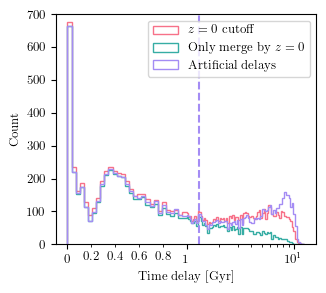

In [29]:
linear_bins = np.linspace(0, 1, 30)  # Linear bins from 0 to 1 Gyr
log_bins_positive = np.logspace(0, np.log10(max(time_delays)), 76)  # Logarithmic bins for values > 1 Gyr

# Combine the bins
bins = np.concatenate((linear_bins[:-1], log_bins_positive))

# plot the distribution of time delays
plt.figure(figsize=(10/3, 3))
plt.hist(time_delays, bins = bins, label=r'$z=0$ cutoff', histtype='step', density=False, color=colour_map[0])
plt.hist(time_delays_without_non_mergers, bins = bins, label='Only merge by $z=0$', histtype='step', density=False, color=colour_map[4])
plt.hist(all_time_delays_artificial, bins = bins, label='Artificial delays', histtype='step', density = False, color=colour_map[6])
plt.xlabel('Time delay [Gyr]')
plt.ylabel('Count')
plt.xscale('symlog',linthresh = 1)
plt.axvline(1.3, color = colour_map[6], linestyle = '--')

# Set minor ticks for linear and log regions
minor_ticks = [0.2, 0.4, 0.6, 0.8, 1.0, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.gca().xaxis.set_minor_locator(FixedLocator(minor_ticks))

def custom_minor_formatter(x, pos):
    if x in [0.2, 0.4, 0.6, 0.8]:  # Choose which minor ticks to label
        return f'{x}'
    else:
        return ''

plt.gca().xaxis.set_minor_formatter(FuncFormatter(custom_minor_formatter))

labels = [item.get_text() for item in plt.gca().get_xticklabels()]
labels[1] = '1'

plt.gca().set_xticklabels(labels)
plt.ylim(0, 700)
plt.legend()
plt.tight_layout()
plt.savefig('../figures/time_delays.png', dpi=600)

### Cumulative number of mergers as a function of redshift

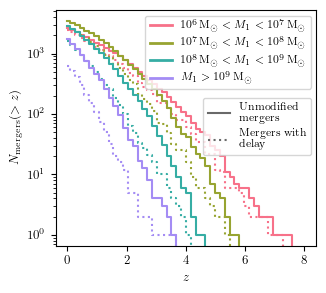

In [30]:
no_delays_6 = []
no_delays_7 = []
no_delays_8 = []
no_delays_9 = []

delays_6 = []
delays_7 = []
delays_8 = []
delays_9 = []

for i, redshift in enumerate(simulation_redshifts):
    m1 = primary_mass[i]
    if m1 >= 1e9:
        no_delays_9.append(redshift)
    elif m1 >= 1e8:
        no_delays_8.append(redshift)
    elif m1 >= 1e7:
        no_delays_7.append(redshift)
    elif m1 >= 1e6:
        no_delays_6.append(redshift)

for i, redshift in enumerate(redshifts_galaxies):
    m1 = primary_mass[i]
    if galaxies_merged[i]:
        if m1 >= 1e9:
            delays_9.append(redshift)
        elif m1 >= 1e8:
            delays_8.append(redshift)
        elif m1 >= 1e7:
            delays_7.append(redshift)
        elif m1 >= 1e6:
            delays_6.append(redshift)

# create redshift bins and then calculate the cumulative number of mergers in each bin (i.e. mergers with z > z_bin)
z_bins = np.linspace(0, 8, 50)
cumulative_no_delays_6 = []
cumulative_no_delays_7 = []
cumulative_no_delays_8 = []
cumulative_no_delays_9 = []

cumulative_delays_6 = []
cumulative_delays_7 = []
cumulative_delays_8 = []
cumulative_delays_9 = []

for z in z_bins:
    cumulative_no_delays_6.append(len([redshift for redshift in no_delays_6 if redshift > z]))
    cumulative_no_delays_7.append(len([redshift for redshift in no_delays_7 if redshift > z]))
    cumulative_no_delays_8.append(len([redshift for redshift in no_delays_8 if redshift > z]))
    cumulative_no_delays_9.append(len([redshift for redshift in no_delays_9 if redshift > z]))

    cumulative_delays_6.append(len([redshift for redshift in delays_6 if redshift > z]))
    cumulative_delays_7.append(len([redshift for redshift in delays_7 if redshift > z]))
    cumulative_delays_8.append(len([redshift for redshift in delays_8 if redshift > z]))
    cumulative_delays_9.append(len([redshift for redshift in delays_9 if redshift > z]))
                               
cumulative_no_delays_6 = np.array(cumulative_no_delays_6)
cumulative_no_delays_7 = np.array(cumulative_no_delays_7)
cumulative_no_delays_8 = np.array(cumulative_no_delays_8)
cumulative_no_delays_9 = np.array(cumulative_no_delays_9)

cumulative_delays_6 = np.array(cumulative_delays_6)
cumulative_delays_7 = np.array(cumulative_delays_7)
cumulative_delays_8 = np.array(cumulative_delays_8)
cumulative_delays_9 = np.array(cumulative_delays_9)

plt.figure(figsize=(10/3, 3))
plt.plot(z_bins, cumulative_no_delays_6, color=colour_map[0], label=r'$10^6 M_\odot < M_1 < 10^7 M_\odot$', drawstyle = 'steps-mid')
plt.plot(z_bins,cumulative_delays_6, color=colour_map[0], linestyle=':', drawstyle = 'steps-mid')
plt.plot(z_bins, cumulative_no_delays_7, color=colour_map[2], label=r'$10^7 M_\odot < M_1 < 10^8 M_\odot$', drawstyle = 'steps-mid')
plt.plot(z_bins, cumulative_delays_7, color=colour_map[2], linestyle=':', drawstyle = 'steps-mid')
plt.plot(z_bins, cumulative_no_delays_8, color=colour_map[4], label=r'$10^8 M_\odot < M_1 < 10^9 M_\odot$', drawstyle = 'steps-mid')
plt.plot(z_bins, cumulative_delays_8, color=colour_map[4], linestyle=':', drawstyle = 'steps-mid')
plt.plot(z_bins, cumulative_no_delays_9, color=colour_map[6], label=r'$M_1 > 10^9 M_\odot$', drawstyle = 'steps-mid')
plt.plot(z_bins, cumulative_delays_9, color=colour_map[6], linestyle=':', drawstyle = 'steps-mid')
from matplotlib.lines import Line2D

# Legend handles for mass bins (colours)
mass_handles = [
    Line2D([0], [0], color=colour_map[0], lw=2, label=r'$10^6 \, \text{M}_\odot < M_1 < 10^7 \, \text{M}_\odot$'),
    Line2D([0], [0], color=colour_map[2], lw=2, label=r'$10^7 \, \text{M}_\odot < M_1 < 10^8 \, \text{M}_\odot$'),
    Line2D([0], [0], color=colour_map[4], lw=2, label=r'$10^8  \, \text{M}_\odot < M_1 < 10^9\, \text{M}_\odot$'),
    Line2D([0], [0], color=colour_map[6], lw=2, label=r'$M_1 > 10^9 \, \text{M}_\odot$'),
]

# Legend handles for models (linestyles)
model_handles = [
    Line2D([0], [0], color='dimgrey', linestyle='-', lw=1.5, label='Unmodified \n mergers'),
    Line2D([0], [0], color='dimgrey', linestyle=':', lw=1.5, label='Mergers with \n delay'),
]

first_legend = plt.legend(
    handles=mass_handles,
    fontsize=8,
    title_fontsize=9,
    loc='upper right',
    bbox_to_anchor=(1.0, 1.0)
)
plt.gca().add_artist(first_legend)

# Second legend: Models (directly under the first)
plt.legend(
    handles=model_handles,
    fontsize=8,
    title_fontsize=9,
    loc='upper right',
    bbox_to_anchor=(1.0, 0.65),
)
plt.yscale('log')
plt.xlabel(r'$z$')
plt.ylabel(r'$N_\text{mergers}(>z)$')
plt.tight_layout()
plt.savefig('../figures/cumulative_mergers_redshift.png', dpi=600)

### BH vs. Host Subhalo Separations

In [15]:
# first need to load the BH separations from the extended merger files
extended_files_path = '/cosma7/data/dp012/dc-butt3/new_merger_events_extended/'

bh_separations = []

for index in indices:
    file_path = os.path.join(extended_files_path, f'{index}.hdf5')
    if os.path.exists(file_path):
        with h5py.File(file_path, 'r') as f:
            header = dict(f['Header'].attrs)
            bh_separation = header['binary_sep']
            bh_separations.append(bh_separation)
    else:
        print(f"File {file_path} does not exist.")

Median separation of galaxies:  68.05263411327265
Median separation of BHs:  1.6555622581719072
Median separation of galaxies (merged):  44.07351883470509


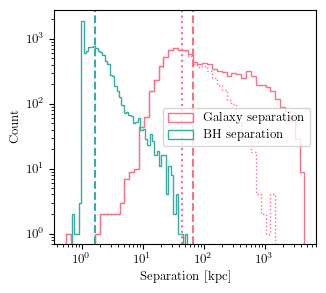

In [ ]:
galaxy_separation = np.array(galaxy_separation)
min_sep = np.min(galaxy_separation[galaxy_separation > 0])  # Minimum separation (exclude non-positive values)
max_sep = np.max(galaxy_separation)
bins = np.logspace(np.log10(min_sep), np.log10(max_sep), 50)  # 50 log-spaced bins

# Remove the not merged indices from galaxy_separation
galaxy_separation_merged = np.delete(galaxy_separation, not_merged_indices)

new_bh_separations = np.array(bh_separations)/1000 # converting to kpc
min_bh_sep = np.min(new_bh_separations[new_bh_separations > 0])  # Minimum separation (exclude non-positive values)
max_bh_sep = np.max(new_bh_separations)
bins_bh = np.logspace(np.log10(min_bh_sep), np.log10(max_bh_sep), 50)  # 50 log-spaced bins

# calculate the mean separation in both cases
mean_separation_galaxy = np.median(galaxy_separation)
mean_separation_bh = np.median(new_bh_separations)
mean_separation_galaxy_merged = np.median(galaxy_separation_merged)

print('Median separation of galaxies: ', mean_separation_galaxy)
print('Median separation of BHs: ', mean_separation_bh)
print('Median separation of galaxies (merged): ', mean_separation_galaxy_merged)

plt.figure(figsize=(10/3, 3))
plt.hist(galaxy_separation, bins = bins, histtype='step', label='Galaxy separation', color=colour_map[0])
plt.hist(new_bh_separations, bins=bins_bh, histtype='step', label='BH separation', color=colour_map[4])
plt.hist(galaxy_separation_merged, bins=bins, histtype='step', color=colour_map[0], linestyle=':')
plt.axvline(mean_separation_galaxy, color=colour_map[0], linestyle='--')
plt.axvline(mean_separation_bh, color=colour_map[4], linestyle='--')
plt.axvline(mean_separation_galaxy_merged, color=colour_map[0], linestyle=':')
plt.xlabel('Separation [kpc]')
plt.ylabel('Count')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/host_separation.png', dpi=600)

## Results with accretion

First read the accretion data from the relevant directory

In [5]:
accretion_path = '/cosma7/data/dp012/dc-butt3/accretion_details/' # change this to the path where the accretion files are stored
primary_mass_accreted = []
secondary_mass_accreted = []

for index in indices:
    filename = f'{index}.txt'
    with open(os.path.join(accretion_path, f'{index}.txt'), 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if line == '\n':
                break
        entries_primary = lines[i-1].strip().split()
        m1 = float(entries_primary[1])
        entries_secondary = lines[-1].strip().split()
        m2 = float(entries_secondary[1])
        if m1 < m2:
            primary_mass_accreted.append(m2)
            secondary_mass_accreted.append(m1)
        else:
            primary_mass_accreted.append(m1)
            secondary_mass_accreted.append(m2)

### Mass Histograms

In [7]:
# group results to plot based on whether delayed merger happens before redshift 0
primary_masses_of_mergers = np.array([])
secondary_masses_of_mergers = np.array([])
chirp_masses_of_mergers = np.array([])
primary_masses_no_delay = np.array([])
secondary_masses_no_delay = np.array([])
primary_masses_accretion = np.array([])
secondary_masses_accretion = np.array([])
chirp_masses_accretion = np.array([])
chirp_masses_no_delay = np.array([])
mass_ratios_of_mergers = np.array([])
mass_ratios_no_delay = np.array([])
mass_ratio_accretion = np.array([])

simulation_redshifts = np.array(simulation_redshifts)
log_simulation_redshifts = np.log10(simulation_redshifts + 1)

final_redshifts_of_mergers = []
final_redshifts_of_mergers = np.array(final_redshifts_of_mergers)


for i, merged in enumerate(galaxies_merged):
    chirp_mass = (primary_mass[i] * secondary_mass[i])**(3/5) / (primary_mass[i] + secondary_mass[i])**(1/5)
    mass_ratio = secondary_mass[i] / primary_mass[i]
    if merged:
        primary_masses_of_mergers = np.append(primary_masses_of_mergers, primary_mass[i])
        secondary_masses_of_mergers = np.append(secondary_masses_of_mergers, secondary_mass[i])
        chirp_masses_of_mergers = np.append(chirp_masses_of_mergers, chirp_mass)
        mass_ratios_of_mergers = np.append(mass_ratios_of_mergers, mass_ratio)
        final_redshifts_of_mergers = np.append(final_redshifts_of_mergers, redshifts_galaxies[i])

        primary_masses_accretion = np.append(primary_masses_accretion, primary_mass_accreted[i])
        secondary_masses_accretion = np.append(secondary_masses_accretion, secondary_mass_accreted[i])
        chirp_mass_accretion = (primary_mass_accreted[i] * secondary_mass_accreted[i])**(3/5) / (primary_mass_accreted[i] + secondary_mass_accreted[i])**(1/5)
        chirp_masses_accretion = np.append(chirp_masses_accretion, chirp_mass_accretion)
        mass_ratio_accreted = secondary_mass_accreted[i] / primary_mass_accreted[i]
        mass_ratio_accretion = np.append(mass_ratio_accretion, mass_ratio_accreted)

    primary_masses_no_delay = np.append(primary_masses_no_delay, primary_mass[i])
    secondary_masses_no_delay = np.append(secondary_masses_no_delay, secondary_mass[i])
    chirp_masses_no_delay = np.append(chirp_masses_no_delay, chirp_mass)
    mass_ratios_no_delay = np.append(mass_ratios_no_delay, mass_ratio)

final_redshifts_of_mergers_log = np.log10(final_redshifts_of_mergers + 1)

# Bins for primary masses

log_mass_bins = np.logspace(np.log10(min(primary_masses_of_mergers)), 12, num=50)  # Adjust `num` as needed
bin_centers = 0.5 * (log_mass_bins[1:] + log_mass_bins[:-1])

log_mass_bins_no_delay = np.logspace(np.log10(min(primary_masses_no_delay)), 12, num=50)  # Adjust `num` as needed
bin_centers_no_delay = 0.5 * (log_mass_bins_no_delay[1:] + log_mass_bins_no_delay[:-1])

log_mass_bins_accretion = np.logspace(np.log10(min(primary_masses_accretion)), 12, num=50)  # Adjust `num` as needed

bin_centers_accretion = 0.5 * (log_mass_bins_accretion[1:] + log_mass_bins_accretion[:-1])

counts, _ = np.histogram(primary_masses_of_mergers, bins=log_mass_bins)
counts_no_delay, _ = np.histogram(primary_masses_no_delay, bins=log_mass_bins_no_delay)
counts_accretion, _ = np.histogram(primary_masses_accretion, bins=log_mass_bins_accretion)

bin_widths = np.diff(np.log10(log_mass_bins))
dn_dlogM = counts / bin_widths / VOLUME

bin_widths_no_delay = np.diff(np.log10(log_mass_bins_no_delay))
dn_dlogM_no_delay = counts_no_delay / bin_widths_no_delay / VOLUME

bin_widths_accretion = np.diff(np.log10(log_mass_bins_accretion))
dn_dlogM_accretion = counts_accretion / bin_widths_accretion / VOLUME

# Bins for secondary masses

log_mass_bins_secondary = np.logspace(np.log10(min(secondary_masses_of_mergers)), np.log10(max(secondary_masses_of_mergers)), num=50)  # Adjust `num` as needed
bin_centers_secondary = 0.5 * (log_mass_bins_secondary[1:] + log_mass_bins_secondary[:-1])

log_mass_bins_secondary_no_delay = np.logspace(np.log10(min(secondary_masses_no_delay)), np.log10(max(secondary_masses_no_delay)), num=50)  # Adjust `num` as needed
bin_centers_secondary_no_delay = 0.5 * (log_mass_bins_secondary_no_delay[1:] + log_mass_bins_secondary_no_delay[:-1])

log_mass_bins_secondary_accretion = np.logspace(np.log10(min(secondary_masses_accretion)), np.log10(max(secondary_masses_accretion)), num=50)  # Adjust `num` as needed
bin_centers_secondary_accretion = 0.5 * (log_mass_bins_secondary_accretion[1:] + log_mass_bins_secondary_accretion[:-1])

counts_secondary, _ = np.histogram(secondary_masses_of_mergers, bins=log_mass_bins_secondary)
counts_secondary_no_delay, _ = np.histogram(secondary_masses_no_delay, bins=log_mass_bins_secondary_no_delay)
counts_secondary_accretion, _ = np.histogram(secondary_masses_accretion, bins=log_mass_bins_secondary_accretion)

bin_widths_secondary = np.diff(np.log10(log_mass_bins_secondary))
dn_dlogM_secondary = counts_secondary / bin_widths_secondary / VOLUME

bin_widths_secondary_no_delay = np.diff(np.log10(log_mass_bins_secondary_no_delay))
dn_dlogM_secondary_no_delay = counts_secondary_no_delay / bin_widths_secondary_no_delay / VOLUME

bin_widths_secondary_accretion = np.diff(np.log10(log_mass_bins_secondary_accretion))
dn_dlogM_secondary_accretion = counts_secondary_accretion / bin_widths_secondary_accretion / VOLUME

# Bins for chirp masses
log_chirp_mass_bins = np.logspace(np.log10(min(chirp_masses_of_mergers)), np.log10(max(chirp_masses_of_mergers)), num=50)
bin_centers_chirp = 0.5 * (log_chirp_mass_bins[1:] + log_chirp_mass_bins[:-1])

log_chirp_mass_bins_no_delay = np.logspace(np.log10(min(chirp_masses_no_delay)), np.log10(max(chirp_masses_no_delay)), num=50)
bin_centers_chirp_no_delay = 0.5 * (log_chirp_mass_bins_no_delay[1:] + log_chirp_mass_bins_no_delay[:-1])

log_chirp_mass_bins_accretion = np.logspace(np.log10(min(chirp_masses_accretion)), np.log10(max(chirp_masses_accretion)), num=50)
bin_centers_chirp_accretion = 0.5 * (log_chirp_mass_bins_accretion[1:] + log_chirp_mass_bins_accretion[:-1])

counts_chirp, _ = np.histogram(chirp_masses_of_mergers, bins=log_chirp_mass_bins)
counts_chirp_no_delay, _ = np.histogram(chirp_masses_no_delay, bins=log_chirp_mass_bins_no_delay)
counts_chirp_accretion, _ = np.histogram(chirp_masses_accretion, bins=log_chirp_mass_bins_accretion)

bin_widths_chirp = np.diff(np.log10(log_chirp_mass_bins))
dn_dlogM_chirp = counts_chirp / bin_widths_chirp / VOLUME

bin_widths_chirp_no_delay = np.diff(np.log10(log_chirp_mass_bins_no_delay))
dn_dlogM_chirp_no_delay = counts_chirp_no_delay / bin_widths_chirp_no_delay / VOLUME

bin_widths_chirp_accretion = np.diff(np.log10(log_chirp_mass_bins_accretion))
dn_dlogM_chirp_accretion = counts_chirp_accretion / bin_widths_chirp_accretion / VOLUME

# Plot for mass ratios
linear_mass_ratio_bins = np.linspace(min(mass_ratios_of_mergers), max(mass_ratios_of_mergers), num=50)
bin_centers_mass_ratio = 0.5 * (linear_mass_ratio_bins[1:] + linear_mass_ratio_bins[:-1])

linear_mass_ratio_bins_no_delay = np.linspace(min(mass_ratios_no_delay), max(mass_ratios_no_delay), num=50)
bin_centers_mass_ratio_no_delay = 0.5 * (linear_mass_ratio_bins_no_delay[1:] + linear_mass_ratio_bins_no_delay[:-1])

linear_mass_ratio_bins_accretion = np.linspace(min(mass_ratio_accretion), max(mass_ratio_accretion), num=50)
bin_centers_mass_ratio_accretion = 0.5 * (linear_mass_ratio_bins_accretion[1:] + linear_mass_ratio_bins_accretion[:-1])

counts_mass_ratio, _ = np.histogram(mass_ratios_of_mergers, bins=linear_mass_ratio_bins)
counts_mass_ratio_no_delay, _ = np.histogram(mass_ratios_no_delay, bins=linear_mass_ratio_bins_no_delay)
counts_mass_ratio_accretion, _ = np.histogram(mass_ratio_accretion, bins=linear_mass_ratio_bins_accretion)

bin_widths_mass_ratio = np.diff(linear_mass_ratio_bins)
dn_dlogM_mass_ratio = counts_mass_ratio / bin_widths_mass_ratio / VOLUME

bin_widths_mass_ratio_no_delay = np.diff(linear_mass_ratio_bins_no_delay)
dn_dlogM_mass_ratio_no_delay = counts_mass_ratio_no_delay / bin_widths_mass_ratio_no_delay / VOLUME

bin_widths_mass_ratio_accretion = np.diff(linear_mass_ratio_bins_accretion)
dn_dlogM_mass_ratio_accretion = counts_mass_ratio_accretion / bin_widths_mass_ratio_accretion / VOLUME


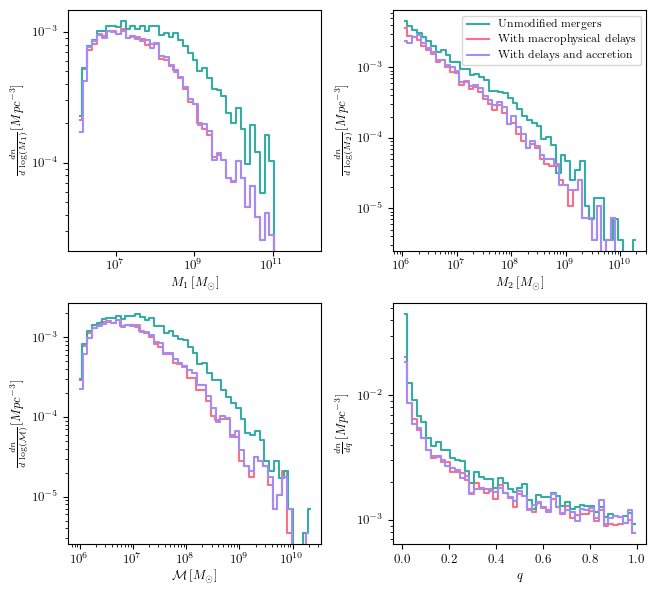

In [8]:
# Set up figure and axes for subplots (4 subplots in a 2x2 grid)
fig, axs = plt.subplots(2, 2, figsize=(20/3, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Primary Mass Distribution
axs[0, 0].plot(bin_centers, dn_dlogM, drawstyle='steps-mid', label=r'$dN/d\log(M)$', color = colour_map[0])
axs[0, 0].plot(bin_centers_no_delay, dn_dlogM_no_delay, drawstyle='steps-mid', label=r'No delay', color = colour_map[4])
axs[0, 0].plot(bin_centers_accretion, dn_dlogM_accretion, drawstyle='steps-mid', label=r'With accretion', color = colour_map[6])
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel(r'$M_1 \, [M_{\odot}]$')
axs[0, 0].set_ylabel(r'$\frac{dn}{d\log(M_1)} [Mpc^{-3}]$')
# axs[0, 0].legend()

# Secondary Mass Distribution
axs[0, 1].plot(bin_centers_secondary_no_delay, dn_dlogM_secondary_no_delay, drawstyle='steps-mid', label='Unmodified mergers', color = colour_map[4])
axs[0, 1].plot(bin_centers_secondary, dn_dlogM_secondary, drawstyle='steps-mid', label='With macrophysical delays', color = colour_map[0])
axs[0, 1].plot(bin_centers_secondary_accretion, dn_dlogM_secondary_accretion, drawstyle='steps-mid', label='With delays and accretion', color = colour_map[6])
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel(r'$M_2 \, [M_{\odot}]$')
axs[0, 1].set_ylabel(r'$\frac{dn}{d\log(M_2)} [Mpc^{-3}]$')
axs[0, 1].legend(fontsize=8)

# Chirp Mass Distribution
axs[1, 0].plot(bin_centers_chirp, dn_dlogM_chirp, drawstyle='steps-mid', label=r'Chirp mass', color = colour_map[0])
axs[1, 0].plot(bin_centers_chirp_no_delay, dn_dlogM_chirp_no_delay, drawstyle='steps-mid', label=r'No delay', color = colour_map[4])
axs[1, 0].plot(bin_centers_chirp_accretion, dn_dlogM_chirp_accretion, drawstyle='steps-mid', label=r'With accretion', color = colour_map[6])
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel(r'$\mathcal{M} \, [M_{\odot}]$')
axs[1, 0].set_ylabel(r'$\frac{dn}{d\log(\mathcal{M})} [Mpc^{-3}]$')
# axs[1, 0].legend()

# Redshift Distribution
axs[1,1].plot(bin_centers_mass_ratio, dn_dlogM_mass_ratio, drawstyle='steps-mid', label=r'$dN/dM_{\mathrm{ratio}}$', color = colour_map[0])
axs[1,1].plot(bin_centers_mass_ratio_no_delay, dn_dlogM_mass_ratio_no_delay, drawstyle='steps-mid', label=r'$dN/dM_{\mathrm{ratio}}$ no delay', color = colour_map[4])
axs[1,1].plot(bin_centers_mass_ratio_accretion, dn_dlogM_mass_ratio_accretion, drawstyle='steps-mid', label=r'$dN/dM_{\mathrm{ratio}}$ with accretion', color = colour_map[6])
axs[1,1].set_xscale('linear')
axs[1,1].set_yscale('log')
axs[1,1].set_xlabel(r'$q$')
axs[1,1].set_ylabel(r'$\frac{dn}{dq} [Mpc^{-3}]$')
# axs[1, 1].legend()

# Save and display the combined plot
plt.tight_layout()
plt.savefig('../figures/mass_histograms.png', dpi=600)

### Redshift-chirpmass contour plot.
Note that the LISA SNR curves were generated using the BOWIE code and are not included in this notebook

In [9]:
chirp_masses_all_log = np.log10(chirp_masses_no_delay)
chirp_masses_delay_log = np.log10(chirp_masses_of_mergers)
chirp_masses_accreted_log = np.log10(chirp_masses_accretion)

# reflect the data in the x axis to avoid edge effects
chirp_masses_all_log_reflected = np.concatenate((chirp_masses_all_log, chirp_masses_all_log))
log_simulation_redshifts_reflected = np.concatenate((log_simulation_redshifts, -log_simulation_redshifts))
chirp_masses_delay_log_reflected = np.concatenate((chirp_masses_delay_log, chirp_masses_delay_log))
final_redshifts_of_mergers_log_reflected = np.concatenate((final_redshifts_of_mergers_log, -final_redshifts_of_mergers_log))
chirp_masses_accreted_log_reflected = np.concatenate((chirp_masses_accreted_log, chirp_masses_accreted_log))

simulation_redshifts_reflected = np.concatenate((simulation_redshifts, -simulation_redshifts))
final_redshifts_of_mergers_reflected = np.concatenate((final_redshifts_of_mergers, -final_redshifts_of_mergers))

chirp_masses_all_reflected = np.concatenate((chirp_masses_no_delay, chirp_masses_no_delay))
chirp_masses_delay_reflected = np.concatenate((chirp_masses_of_mergers, chirp_masses_of_mergers))
chirp_masses_accreted_reflected = np.concatenate((chirp_masses_accretion, chirp_masses_accretion))

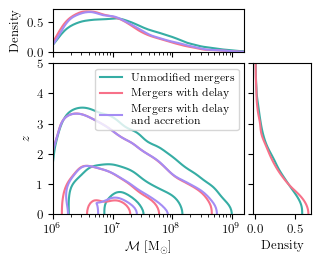

In [10]:
# Define figure layout
fig = plt.figure(figsize=(10/3, 3.5))  # Adjust size as needed
grid = plt.GridSpec(6, 4, hspace=0.3, wspace=0.15, height_ratios=[1, 1, 1, 1, 0.7, 0.3])  
# Define axes
main_ax = fig.add_subplot(grid[1:4, :-1])  # Main KDE plot
top_ax = fig.add_subplot(grid[0, :-1])  # Top marginal
right_ax = fig.add_subplot(grid[1:4, -1])  # Right marginal

# KDE Contour Plots (Main Plot)
levels = [0.1, 0.5, 0.9]
sns.kdeplot(x=chirp_masses_all_reflected, y=simulation_redshifts_reflected, 
            color=colour_map[4], levels=levels, ax=main_ax, log_scale=(True, False))

sns.kdeplot(x=chirp_masses_delay_reflected, y=final_redshifts_of_mergers_reflected, 
            color=colour_map[0], levels=levels, ax=main_ax, log_scale=(True, False))

sns.kdeplot(x=chirp_masses_accreted_reflected, y=final_redshifts_of_mergers_reflected, 
            color=colour_map[6], levels=levels, ax=main_ax, log_scale=(True, False))

# Marginal KDE plots
sns.kdeplot(x=chirp_masses_all_reflected, color=colour_map[4], ax=top_ax, log_scale=True)
sns.kdeplot(x=chirp_masses_delay_reflected, color=colour_map[0], ax=top_ax, log_scale=True)
sns.kdeplot(x=chirp_masses_accreted_reflected, color=colour_map[6], ax=top_ax, log_scale=True)

redshift_kde = gaussian_kde(simulation_redshifts_reflected)
redshift_kde_modified = gaussian_kde(final_redshifts_of_mergers_reflected)
z_values = np.linspace(0, 5, 100)

right_ax.plot(2*redshift_kde(z_values), z_values, color=colour_map[4])
right_ax.plot(2*redshift_kde_modified(z_values), z_values, color=colour_map[0])

# Create proxy artists for legend
all_mergers = mlines.Line2D([], [], color=colour_map[4], label='Unmodified mergers')
delayed_mergers = mlines.Line2D([], [], color=colour_map[0], label='Mergers with delay')
accreted_mergers = mlines.Line2D([], [], color=colour_map[6], linestyle='-', label='Mergers with delay \n and accretion')

# Ensure tick labels are shown in the main plot
main_ax.tick_params(axis='x', which='both', labelbottom=True)
main_ax.tick_params(axis='y', which='both', labelleft=True)

# Set ticks on the top and right marginal plots, but remove the labels
top_ax.set_xticks(main_ax.get_xticks())  # Use ticks from the main plot for shared axis
right_ax.set_yticks([0, 1, 2, 3, 4, 5])

top_ax.set_xticklabels([])  # Remove x-tick labels on the top marginal plot
right_ax.set_yticklabels([])  # Remove y-tick labels on the right marginal plot

# Labels
main_ax.set_xlabel(r"$\mathcal{M}$ [M$_\odot$]")  
main_ax.set_ylabel(r'$z$')

# Set axis limits
main_ax.set_xlim(1e6, 10**(9.2))  
main_ax.set_ylim(0, 5)    
top_ax.set_xlim(main_ax.get_xlim())
right_ax.set_ylim(main_ax.get_ylim())   

right_ax.set_xlabel(r'Density')

# Add legend
main_ax.legend(handles=[all_mergers, delayed_mergers, accreted_mergers], fontsize=8)

# Save and show
plt.savefig('../figures/redshift_chirpmass_contour.png', dpi=600, bbox_inches='tight')


### Eddington Ratios
Need to generate fable_eddington_ratios.txt file first using eddington_rates.py

In [7]:
path_to_file_primary = '../data/generated_data/fable_eddington_ratios_primary.txt'
path_to_file_secondary = '../data/generated_data/fable_eddington_ratios_secondary.txt'
simulation_data_primary = np.loadtxt(path_to_file_primary)
simulation_data_secondary = np.loadtxt(path_to_file_secondary)
eddington_fractions_primary = simulation_data_primary[:,-1]
eddington_fractions_secondary = simulation_data_secondary[:,-1]
eddington_fractions_fable = np.concatenate((eddington_fractions_primary, eddington_fractions_secondary))

In [5]:
def eddington_rate(M_BH):
    epsilon_r = 0.1
    M_BH = M_BH*u.Msun
    eddington_rate = 4*np.pi*const.G*M_BH*const.m_p/(0.1*const.sigma_T*const.c)
    return eddington_rate.to(u.Msun/u.Gyr).value

In [8]:
# Read the eddington fractions from the accretion detail files, in the snap before subhalo merger
scale_factors = util.get_scale_factors()
path_to_accretion_data = '/cosma7/data/dp012/dc-butt3/accretion_details/'
path_to_merger_files = '/cosma7/data/dp012/dc-butt3/new_merger_events_extended/'
eddington_fractions_primary_accreted = []
eddington_fractions_secondary_accreted = []
files = os.listdir(path_to_accretion_data)
indices_of_accretion_data = []
for file in files:
    index = file.split('.')[0]
    indices_of_accretion_data.append(index)
    id1 = int(index.split('_')[0])
    id2 = int(index.split('_')[1])
    # find the line before the empty line
    with open(path_to_accretion_data + file, 'r') as f:
        lines = f.readlines()
        first_line = lines[0].strip().split()
        if first_line[-1] == -1:
            # this means that the time delay is equal to 0 in my model
            # so I need to get the accretion rates from the simulation from the snap before the numerical merger
            with h5py.File(os.path.join(path_to_merger_files, index + '.hdf5'), 'r') as f:
                header = dict(f['Header'].attrs.items())
                scale_factor = header['formation_scale_factor']
                snap_before = np.where(scale_factors < scale_factor)[0][-1]
            entry = next(
                (e for e in simulation_data_primary if e[0] == id1 and e[1] == snap_before),
                None
            )
            if entry:
                eddington_fractions_primary_accreted.append(entry[2])

            entry = next(
                (e for e in simulation_data_secondary if e[0] == id2 and e[1] == snap_before),
                None
            )
            if entry:
                eddington_fractions_secondary_accreted.append(entry[2])

        else:
            for i, line in enumerate(lines):
                # Get the index of the empty line that separates the two black holes
                if line == '\n':
                    break
            entries_primary = lines[i-1].strip().split()
            primary_mass = float(entries_primary[1])
            eddington_primary = eddington_rate(primary_mass)
            primary_rate = float(entries_primary[2])
            if np.isnan(primary_rate):
                primary_rate = 0
            eddington_fractions_primary_accreted.append(primary_rate/eddington_primary)
            entries_secondary = lines[-1].strip().split()
            secondary_mass = float(entries_secondary[1])
            eddington_secondary = eddington_rate(secondary_mass)
            secondary_rate = float(entries_secondary[2])
            if np.isnan(secondary_rate):
                secondary_rate = 0
            eddington_fractions_secondary_accreted.append(secondary_rate/eddington_secondary)

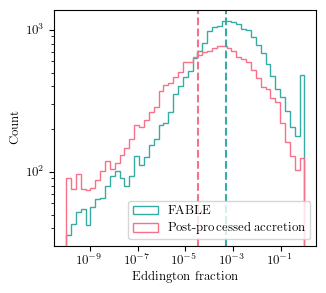

In [11]:
eddington_fractions_accreted = np.concatenate((eddington_fractions_primary_accreted, eddington_fractions_secondary_accreted))

bins = np.logspace(-10, 0, 50)
plt.figure(figsize=(10/3, 3))
plt.hist(eddington_fractions_fable, bins=bins, color=colour_map[4], histtype='step', label='FABLE', density=False)
plt.hist(eddington_fractions_accreted, bins=bins, color=colour_map[0], histtype='step', label='Post-processed accretion',density=False)
plt.axvline(np.median(eddington_fractions_fable), color=colour_map[4], linestyle='--')
plt.axvline(np.median(eddington_fractions_accreted), color=colour_map[0], linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Eddington fraction')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/eddington_fractions.png', dpi = 600)